In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

from matplotlib import rcParams
from tqdm import tqdm


#import warnings
#warnings.filterwarnings("ignore")

# Paths to data

In [4]:
r848_v1_path = 'insert datapath here to ./scRNAseq_data/r848_v1.h5ad'
r848_v2_path = 'insert datapath here to ./scRNAseq_data/r848_v2.h5ad'

ntc_v1_path = 'insert datapath here to ./scRNAseq_data/ntc_v1.h5ad'
ntc_v2_path = 'insert datapath here to ./scRNAseq_data/ntc_v2.h5ad'

lps_v1_path = 'insert datapath here to ./scRNAseq_data/lps_v1.h5ad'
lps_v2_path = 'insert datapath here to ./scRNAseq_data/lps_v2.h5ad'


# Figure 4a - preparing for NicheNet

In [7]:
#For LPS-pathways, monocyte influence of NK and CD8T cells
V1 = sc.read(lps_v1_path)
V2 = sc.read(lps_v2_path)
V1.obs['V'] = 'V1'
V2.obs['V'] = 'V2'
V1.var_names_make_unique()
V2.var_names_make_unique()
V1.obs_names_make_unique()
V2.obs_names_make_unique()


add = ad.concat([V1, V2])
add.obs_names_make_unique()


df = add.to_df()

#Filtering some genes, with counts < 3k
summ = np.sum(df, axis = 0)
summ = summ[summ > 3000]

df = df[summ.index]
df_meta = add.obs

df.to_csv('insert pathway to later be read in R')
df_meta.to_csv('insert pathway to later be read in R')

#... and off to NicheNet_Figure4A.R we go

/Users/rikardforlin/opt/miniconda3/envs/minic/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Get the ct with the largest change in NicheNet targets

In [31]:
target_list = [
    "GZMB", "IFNG", "SOCS1", "CD38", "ABCB1", "IL2RA", "PRF1", 
    "IRF4", "RUNX3", "KLRD1", "STAT4", "CDK6", "IL12RB2", "NKG7", "IL15RA"
]

In [35]:
max_gene_value = {}
max_gene_ct = {}

df1 = add[(add.obs.V == 'V1') & (add.obs.CellType == 'NK')].to_df()
df2 = add[(add.obs.V == 'V2') & (add.obs.CellType == 'NK')].to_df()
for gene in target_list:
    gene_value = np.mean(df2[gene]) - np.mean(df1[gene])
    max_gene_value[gene] = gene_value
    max_gene_ct[gene] = 'NK'
    

df1 = add[(add.obs.V == 'V1') & (add.obs.CellType == 'CD8T')].to_df()
df2 = add[(add.obs.V == 'V2') & (add.obs.CellType == 'CD8T')].to_df()
for gene in target_list:
    gene_value = np.mean(df2[gene]) - np.mean(df1[gene])

    if max_gene_value[gene] < gene_value:
        max_gene_value[gene] = gene_value
        max_gene_ct[gene] = ct


In [36]:
max_gene_ct

{'GZMB': 'NK',
 'IFNG': 'NK',
 'SOCS1': 'CD8T',
 'CD38': 'NK',
 'ABCB1': 'NK',
 'IL2RA': 'NK',
 'PRF1': 'NK',
 'IRF4': 'NK',
 'RUNX3': 'CD8T',
 'KLRD1': 'NK',
 'STAT4': 'NK',
 'CDK6': 'NK',
 'IL12RB2': 'NK',
 'NKG7': 'NK',
 'IL15RA': 'NK'}

# Figure 4f - NK cells IL12RB1 and IL12RB2

In [3]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)


sc.pp.normalize_total(lps_v1, target_sum=1e4)
sc.pp.normalize_total(lps_v2, target_sum=1e4)

ct = 'NK'
stim_v1 = lps_v1[lps_v1.obs.CellType == ct].to_df() 
stim_v2 = lps_v2[lps_v2.obs.CellType == ct].to_df()

stim_v1 = stim_v1.groupby(axis=1, level=0).sum()
stim_v2 = stim_v2.groupby(axis=1, level=0).sum()

stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [4]:

v1bar = pd.DataFrame({'gene': ['IL12RB1', 'IL12RB2'], 'value': [np.mean(np.log1p(stim_v1['IL12RB1'])), np.mean(np.log1p(stim_v1['IL12RB2']))], 'V':['V1', 'V1']})
v2bar = pd.DataFrame({'gene':['IL12RB1', 'IL12RB2'], 'value': [np.mean(np.log1p(stim_v2['IL12RB1'])), np.mean(np.log1p(stim_v2['IL12RB2']))], 'V':['V2', 'V2']})

bardf = pd.concat([v1bar, v2bar])

Text(0, 0.5, 'Mean of log2-values')

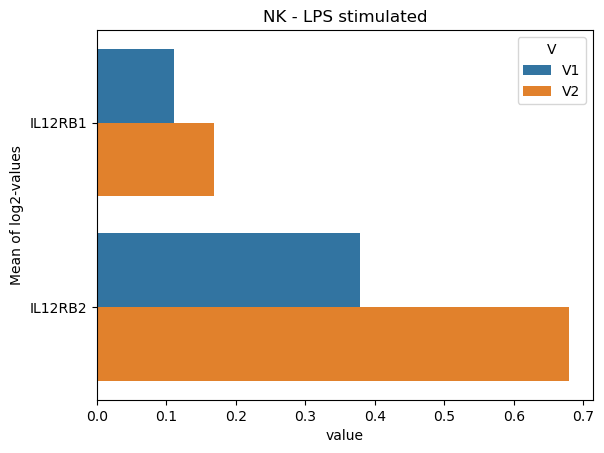

In [5]:
sns.barplot(y = 'gene', x = 'value', hue = 'V', data = bardf)
plt.title('NK - LPS stimulated')
plt.ylabel('Mean of log2-values')
#plt.savefig('NK_LPS_IL12RB.pdf')

In [6]:
print(scipy.stats.ttest_ind(np.log1p(stim_v1['IL12RB1']), np.log1p(stim_v2['IL12RB1'])))
print(scipy.stats.ttest_ind(np.log1p(stim_v1['IL12RB2']), np.log1p(stim_v2['IL12RB2'])))

Ttest_indResult(statistic=-3.3923159278596207, pvalue=0.0006988665623761121)
Ttest_indResult(statistic=-9.400133429927449, pvalue=8.34808409334688e-21)
